In [1]:
print('manually leveling')

manually leveling


## Import Section

In [2]:
import numpy as np
import torch
import torchvision
from time import time
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.autograd import Variable
import os
import glob
import cv2
from tqdm import tqdm

from matplotlib.pyplot import imsave, imread
import matplotlib.pyplot as plt
import sys
import matplotlib.gridspec as gridspec

import copy
import pickle

In [3]:
from floodfill import *
from dataloader import *
from model import *
from oracle import *
from unet import *
import ternausnet.models

In [4]:
from vivek.model import *

## Testing Jupyter Notebook Section

In [5]:
#Testing live input from user
users_name = input("what is your name: ")
print(f"Your name is: {users_name}.")

what is your name: alina
Your name is: alina.


(3, 256, 256)


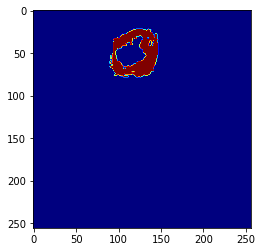

In [64]:
#Tests loading an image from a directory
im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/"
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_10_a/Iter1/UNetSegmentations_ff/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/UNetSegmentations/Iter0_ff/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter2/UNetSegmentations_C/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter2/UNetSegmentations_C/Round/"
# im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_24_b/Iter1/UNetSegmentations_C/Oval/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/UNetSegmentations/Iter0_ff/Round/"
#ims = ["DP_ACRF_18645_1.npy"]
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_02_10_a/Iter1/OracleThresholdedImages_ff/Irregular/"
ims = ["Oval/DP_AGYG_113509_1.npy"]

for im in ims:
    path = im_dir + im;
    arr = np.load(path)
    #arr = np.where(arr > 0.2,1,0)
    print(arr.shape)
    
plt.imshow(arr[1],cmap='jet')
#plt.show()
im_dir = save_dir

## Active Learning: Setup - Run once per run id

In [6]:
run_id = "01_01_b" #Format: Month_Day_(Run # that day by letter)
#run_id = "02_10_a"
#run_id = "02_28_a"
#original 
#01_01_b is where we load from alina's oracle results
#02_28_a is where we load trained model

In [7]:
iter_num=1

In [8]:
im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/"
#im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_02_28_a/Iter1/OracleThresholdedImages_ff/"

In [9]:
#Gets the dataloader. Passes in directory of ALL images
#im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations/train/"
#GET THE NEW IM_DIR FOR SUBSEQUENT ITERATIONS
im_dir = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations_unbin/train/"
dataloader = get_DataLoader(im_dir,32,2)

#Tests the dataloader
for i in tqdm(dataloader):
#     print(max(i[1]))
    print(i[1].shape)
    break

  0%|          | 0/26 [00:00<?, ?it/s]

torch.Size([32, 1, 256, 256])


In [10]:
#Initializing info arrays for active learning. oracle_results maps patientIDs to 0,1 labels
oracle_results = {}
oracle_results_thresholds = {}

## Active Learning: Querying

In [ ]:
#Initializes and trains the model. Plots a loss function of the initial training
model,loss_tracker,criterion,optimizer = initialize_and_train_model(dataloader, epochs=5) #default batch_size and epochs
plt.plot(loss_tracker) #plot graph

In [ ]:
all_patient_scores = []

#right now patient_scores is initial scores for each patient (without active learning training)
patient_scores = get_patient_scores(model,dataloader) 
all_patient_scores.append(patient_scores)

In [ ]:
new_oracle_results, new_oracle_results_thresholds = query_oracle(oracle_results,oracle_results_thresholds,
                                                                 patient_scores,im_dir,query_method="percentile=0.8",
                                                                 query_number=20)
oracle_results, oracle_results_thresholds = new_oracle_results, new_oracle_results_thresholds

In [ ]:

query_num+=2

In [ ]:
patient_scores = get_patient_scores(model,dataloader)
all_patient_scores.append(patient_scores)

In [ ]:
#TODO: track model loss somehow along with patient_scores
for i in range(1):
    model = model_update(model,dataloader,oracle_results,criterion,optimizer,num_epochs=5)

    patient_scores = get_patient_scores(model,dataloader)
    all_patient_scores.append(patient_scores)

## Metrics and plotting

In [ ]:
#Prints out all patient scores.
for i in all_patient_scores:
    print(calculate_dispersion_metric(i,oracle_results))

In [ ]:
#Plot the disperson metric
j = []
for i in all_patient_scores:
    j.append(calculate_dispersion_metric(i,oracle_results))
    
plt.plot(j)

In [ ]:
print("Length of patient scores: " + str(len(patient_scores)))
print("Length of oracle results: " + str(len(oracle_results)))

scores = []
for key in patient_scores.keys():
    scores.append(patient_scores[key])
plt.plot(scores)

ones = 0
for i in oracle_results.keys():
    if oracle_results[i]==1:
        ones+=1
print("Number of ones in oracle results: ", ones)

In [ ]:
run_id

Jump back to oracle query if you want to query more. Move on to retrain segmenter

## Saving or Loading Oracle Results

In [ ]:
if False:
    #SAVE ORACLE

    #make filepath
    if users_name == 'alina':
        save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
    elif users_name == 'vaibhav':
        save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"

    saved_oracle_filepaths = save_oracle_results(oracle_results,oracle_results_thresholds,im_dir,save_dir)
    fpath = save_dir + "saved_data_struct/"
    if not os.path.exists(fpath):
        os.makedirs(fpath)
    saved_oracle_filepaths_filepath = save_dir + "saved_data_struct/Oracle_Filepaths.pickle"
    pickle.dump(saved_oracle_filepaths,open(saved_oracle_filepaths_filepath,"wb"))
    pickle.dump(oracle_results,open(save_dir + "saved_data_struct/Oracle_Results.pickle","wb"))
    pickle.dump(oracle_results_thresholds,open(save_dir + "saved_data_struct/Oracle_Results_Thresholds.pickle","wb"))
    #TODO: Move border/weight creation to this method and out of convert_directory_to_floodfill

In [32]:
len(saved_oracle_filepaths)

238

In [11]:
if False: #done running if False
    #LOAD oracle_results and save_oracle_filepaths
    if users_name == 'alina':
        save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
    elif users_name == 'vaibhav':
        save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
    saved_oracle_filepaths_filepath = save_dir + "saved_data_struct/Oracle_Filepaths.pickle"
    #Reload from previous iteration
    oracle_results = pickle.load(open(save_dir + "saved_data_struct/Oracle_Results.pickle","rb"))
    oracle_results_thresholds = pickle.load(open(save_dir + "saved_data_struct/Oracle_Results_Thresholds.pickle","rb"))
    saved_oracle_filepaths = pickle.load(open(saved_oracle_filepaths_filepath,"rb"))

In [ ]:
if False:
    # RECOVER an accidentally delted oracle (recovers correct segmentations only)
    oracle_results = {}
    if users_name == 'alina':
        recover_from_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/CorrectSegmentations/"
    for root, dirs, files in os.walk(recover_from_dir):
        for file in files:
            if file.endswith(".npy"):
                filepath = os.path.join(root, file)
                print(filepath.split('/')[])
                break
                oracle_results[file[:-4]] = 1

    # pickle.dump(oracle_results,open(recover_from_dir + "saved_data_struct/Oracle_Results.pickle","wb"))

In [12]:
#Remove all 0's from oracle_results.
oracle_results = remove_bad_oracle_results(oracle_results)
#NOTE: Don't FULLY reset oracle_results EVER during a run, only do above

In [12]:
print(len(oracle_results))

313


In [35]:
# #Convert oracle_results to oracle filepaths
# all_oracle_filepaths = []
    
# filestem = '/'.join(saved_oracle_filepaths[0].split("/")[:-2]) +"/"
# print(filestem)

# for key in oracle_results.keys():
#     all_oracle_filepaths.append(filestem + key + ".npy")

# print(len(oracle_all_filepaths))

/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_01_01_b/Iter1/CorrectSegmentations/
313


## Retrain UNet and Save New Segmentations

In [13]:
#Retoggle run id if we want to save today's set instead of loading in an old set.
if True:
    run_id = "03_17_a" 
    
#Retoggle user to Vaibhav if I want to save 
if True:
    users_name = "vaibhav"

In [14]:
#Threshold masks based on oracle and save if needed.
#If already done, then skip
threshold_and_save_flag = True
if threshold_and_save_flag:
    #Save thresholded
    if users_name == 'alina':
        save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/OracleThresholdedImages/"
    elif users_name == 'vaibhav':
        save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/OracleThresholdedImages/"
    else:
        print("wrong username")
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    else:
        user_input = input("Do you want to overwrite this directory? Type y or yes to continue")
        if not (user_input=="y" or user_input=="yes"):
            assert(False)
    #find all filepaths in im_dir
    all_filepaths = []
    for root, dirs, files in os.walk(im_dir):
        for file in files:
            if file.endswith(".npy"):
                all_filepaths.append(os.path.join(root, file))
    threshold_and_save_images(all_filepaths, oracle_results_thresholds, save_dir)
    save_dir = convert_directory_to_floodfill(save_dir,iter0=False)
    print(f"Saved in {save_dir}")
    unbin_im_dir = im_dir
    im_dir = save_dir #im_dir is now replaced with the new directory
    #save_dir is defunct

Do you want to overwrite this directory? Type y or yes to continuey


100%|██████████| 824/824 [05:18<00:00,  2.59it/s]

Saved in /usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_17_a/Iter1/OracleThresholdedImages_ff/


In [15]:
def unet_dataloader(train_images_filepaths,batch_size,num_workers):
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    transform = transforms.Compose(transforms_arr)
    trainset = InhouseGetData(train_images_filepaths,transform,data_aug=True,has_weights=True)
    trainloader = DataLoader(trainset,batch_size=batch_size,num_workers=num_workers)
    return trainloader

class InhouseGetData(Dataset):
    def __init__(self,image_filepaths,image_transform,data_aug=True,has_weights=True):
        super().__init__()
        self.image_filepaths = image_filepaths
        self.image_transform = image_transform
        self.data_aug = data_aug
        self.has_weights = has_weights

    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self,idx):
        filepath = self.image_filepaths[idx]
        #print("Filepath: " + filepath)
        arr_and_mask = np.load(filepath)
        copy_arr_mask = arr_and_mask.copy()
        if self.data_aug:
            copy_arr_mask = random_flip(copy_arr_mask, 0, True)
            copy_arr_mask = random_flip(copy_arr_mask, 1, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
        arr = copy_arr_mask[0,:,:].copy()
        mask = copy_arr_mask[1,:,:].copy()
        if self.has_weights:
            weights = copy_arr_mask[2,:,:].copy()
        arr = exposure.equalize_hist(arr) #histogram equalization, remove if u want
        #arr = np.stack([arr,arr,arr])
        #mask = np.stack([mask,mask,mask])
        #no need to preprocess
        #print("INSIDE")
        #print(arr.shape)
        
        image = self.image_transform(arr)
        #image = our_transform(image)
        #print(image.shape)
        #print("OUTSIDE")
        mask_label = self.image_transform(mask)
        #mask_label = our_transform(mask_label)
        if self.has_weights:
            weights_label = self.image_transform(weights)
            #weights_label = our_transform(weights_label)
        #a transform
        # print(arr.shape)
        # print(mask.shape)
        
        # transformed = self.a_transform(image=arr, mask=mask)
        # a_image = transformed["image"]
        # a_mask = transformed["mask"]
        if self.has_weights:
            return image,mask_label,weights_label
        return image,mask_label


def get_binary_mask(mask,threshold):
    return np.where(mask > threshold, 1, 0)
    
class InhouseGetData_v2(InhouseGetData):
    def __init__(self,image_filepaths,oracle_results_thresholds,image_transform,data_aug=True,has_weights=True):
        InhouseGetData.__init__(self,image_filepaths,image_transform,data_aug,has_weights)
        self.oracle_results_thresholds = oracle_results_thresholds
    def __getitem__(self,idx):
        filepath = self.image_filepaths[idx]
        #print("Filepath: " + filepath)
        arr_and_mask = np.load(filepath)
        copy_arr_mask = arr_and_mask.copy()
        if self.data_aug:
            copy_arr_mask = random_flip(copy_arr_mask, 0, True)
            copy_arr_mask = random_flip(copy_arr_mask, 1, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
            copy_arr_mask = random_rotate_90(copy_arr_mask, True)
        arr = copy_arr_mask[0,:,:].copy()
        mask = copy_arr_mask[1,:,:].copy()
        #apply threshold to mask
        threshold = self.oracle_results_thresholds[("/".join(filepath.split("/")[-2:]))[:-4]]
        mask = get_binary_mask(mask,threshold)
        if self.has_weights:
            weights = copy_arr_mask[2,:,:].copy()
        arr = exposure.equalize_hist(arr) #histogram equalization, remove if u want
        
        image = self.image_transform(arr)
        mask_label = self.image_transform(mask)
        if self.has_weights:
            weights_label = self.image_transform(weights)
        if self.has_weights:
            return image,mask_label,weights_label
        return image,mask_label
        
    
def unet_dataloader_v2(saved_oracle_filepaths,oracle_results_thresholds,batch_size=8,num_workers=2):
    transforms_arr = [transforms.ToTensor(),transforms.Resize((256,256))]
    transform = transforms.Compose(transforms_arr)
    trainset = InhouseGetData_v2(saved_oracle_filepaths,oracle_results_thresholds,transform,data_aug=True,has_weights=True)
    trainloader = DataLoader(trainset,batch_size=batch_size,num_workers=num_workers)
    return trainloader
    

In [16]:
custom_model_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_17_a/Iter1/unetmodel.pth"
custom_load = True
if custom_load:
    model_path = custom_model_path
    unet_model = torch.load(model_path)
    
else:
    #Load in/Initialize a UNet model for retraining

    from_scratch = False
    #Define the initial UNet model (iter0)
    if iter_num==1:
        model_path = "/usr/xtmp/vs196/mammoproj/SavedModels/HyperparameterUNet_nobuffer/unet_5_0.5/Model/unetmodel_FINAL.pth"
    else:
        model_path = model_save_path

    if not from_scratch:
        unet_model = torch.load(model_path)
    else:
        unet_model = getattr(ternausnet.models, "UNet16")(num_classes=2,pretrained=True).cuda()

total_loss_tracker = []
total_metric_tracker = []

In [17]:
#Handles three channels: [data,floodfilled binary mask,border]
def redirect_saved_oracle_filepaths_to_thresheld_directory(saved_oracle_filepaths,im_dir):
    new_filepaths = [(im_dir + "/".join(filepath.split("/")[-2:])) for filepath in saved_oracle_filepaths]
    return new_filepaths

new_saved_oracle_filepaths = redirect_saved_oracle_filepaths_to_thresheld_directory(saved_oracle_filepaths, im_dir)

In [43]:
# print(saved_oracle_filepaths[0])
# print(new_saved_oracle_filepaths[0])
print(im_dir)
print(run_id)

/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_10_a/Iter1/OracleThresholdedImages_ff/
03_10_a


In [19]:
#Retrain UNet with training data taken from OracleImages/Iter
#new_unet_dataloader = unet_dataloader(saved_oracle_filepaths,8,2)
new_unet_dataloader = unet_dataloader(new_saved_oracle_filepaths,8,2)
cbis_trainloader,_ = CBIS_DDSM_get_DataLoader(8,2)

#unet_model,loss_tracker,metric_tracker = unet_update_model(unet_model,cbis_trainloader,num_epochs=15)
unet_model,loss_tracker,metric_tracker = unet_update_model_multi_dataloader(unet_model,new_unet_dataloader,cbis_trainloader,num_epochs=2)
total_loss_tracker.extend(loss_tracker)
total_metric_tracker.extend(metric_tracker)

100%|██████████| 155/155 [02:01<00:00,  1.27it/s]


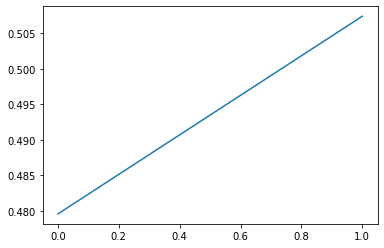

In [20]:
#plt.plot(total_loss_tracker)
plt.plot(total_metric_tracker)

In [18]:
#evaluate new segmentations for ALL images 
#Save SAVED_ORACLE_FILEPATH NEW segmentations to SEPARATE FOLDER for VIEWING ONLY
#Save this iteration saved_oracle_filepaths along with new segmentations for all other patients
segmentation_folder = unbin_im_dir
correct_save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations_C/"
save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/UNetSegmentations/"
#Method creates new segmentations using updated model. 
#Saves new segmentations for images labelled correctly by the oracle to correct_save_dir
#Saves all segmentations (preserved for images labelled correctly by the oracle, new for all others) to save_dir
#Have different subfolders for different iterations of unet update
evaluate_model_on_new_segmentations_and_save(unet_model,segmentation_folder,saved_oracle_filepaths,correct_save_dir,save_dir,iter_num)

#save_dir is what we convert to floodfill two cells down.
#TODO: ADD TQDM TO EVALUATE_MODEL...
#TODO: Add flexibility for alina saving (add alina paths)
#TODO: Update evaluate model to output two channels where the first is the same as now and the second is a continuous version of the mask.
#Look at bad oracles and see if those got better.

  0%|          | 2/824 [00:00<00:38, 21.20it/s]


Debugging. Data shape is: (256, 256), and unbinarized shape is: (256, 256), and unbin output shape is torch.Size([1, 256, 256])
Debugging. Data shape is: (256, 256), and unbinarized shape is: (256, 256), and unbin output shape is torch.Size([1, 256, 256])
Debugging. Data shape is: (256, 256), and unbinarized shape is: (256, 256), and unbin output shape is torch.Size([1, 256, 256])


ValueError: all input arrays must have the same shape

In [22]:
#save the model
model_save_path = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/unetmodel.pth"
torch.save(unet_model,model_save_path)

In [54]:
#save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_02_28_a/Iter1/UNetSegmentations"
iter_num

1

In [45]:
#Convert initial UNet Segmentations to flood-filled and resave
#raw_segmentation_folder = "/usr/xtmp/mammo/image_datasets/data_split_july2021/square_ROI_by_shape_segmentations/train/"
raw_segmentation_folder = save_dir #remove for rerun
im_dir = convert_directory_to_floodfill(raw_segmentation_folder,iter0=False)

100%|██████████| 824/824 [05:29<00:00,  2.50it/s]


In [14]:
iter_num+=1

In [ ]:
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_29_a/Iter1/UNetSegmentations_ff/"
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_02_28_a/Iter1/UNetSegmentations"

In [ ]:
#reloading iter 1 purposes
iter_num = 2
im_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_23_a/Iter1/UNetSegmentations_ff/"
dataloader = get_DataLoader(im_dir,32,2)

In [16]:
print(iter_num)

2


In [46]:
print(im_dir)

/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_03_10_a/Iter1/UNetSegmentations_ff/


# Saving Images for Fides

In [18]:
def display_image_annotation(filepath,annotations):
    ncols, nrows = 3, len(filepath)
    fig = plt.figure(constrained_layout=False)
    fig.set_size_inches(9, 3*len(filepath)+1)
    fig.tight_layout()
    spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig,hspace=0,wspace=0)
    
    anno_opts = dict(xy=(0.05, 0.05), xycoords='axes fraction', va='bottom', ha='left',color='cyan',fontweight='extra bold',fontsize='8')

    f_axes = []
    for row in range(nrows):
        f_axes.append([])
        for col in range(ncols):
            f_axes[-1].append(fig.add_subplot(spec[row, col]))

    for ax_num, ax in enumerate(f_axes[0]):
            if ax_num == 0:
                ax.set_title("Image", fontdict=None, loc='left', color = "k")
            elif ax_num == 1:
                ax.set_title("Segmentation", fontdict=None, loc='left', color = "k")
            elif ax_num == 2:
                ax.set_title("Overlay", fontdict=None, loc='left', color = "k")

    for row in range(nrows):
        image_and_mask = np.load(filepath[row])
        f_axes[row][0].imshow(image_and_mask[0],cmap='gray')
        f_axes[row][0].set_axis_off()
        
        f_axes[row][1].imshow(image_and_mask[1],cmap='gray')
        f_axes[row][1].set_axis_off()

        heatmap = cv2.applyColorMap(np.uint8(255*(1-image_and_mask[1])), cv2.COLORMAP_AUTUMN)
        heatmap = np.float32(heatmap) / 255
        heatmap = heatmap[...,::-1]

        img = 0.6 * np.stack([image_and_mask[0],image_and_mask[0],image_and_mask[0]],axis=-1) + 0.3*heatmap
        f_axes[row][2].imshow(img)
        f_axes[row][2].set_axis_off()
        
        f_axes[row][0].annotate(annotations[row],**anno_opts)

    #plt.show()

In [ ]:
tobechecked_save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/ToBeChecked_neworder/"

exclude_data_from_dirs = ["/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_11_30_a/Iter1/CorrectSegmentations/",
                          "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_12_19_b/Iter1/CorrectSegmentations/",
                          "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_12_21_b/Iter1/CorrectSegmentations/",
                          "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_12_21_b/Iter2/CorrectSegmentations/",
                          "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_01_01_a/Iter1/CorrectSegmentations/"
                         ]

exclude_data_from_dirs = ["/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_01_01_b/Iter1/CorrectSegmentations/",
                          "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_12_21_b/Iter1/CorrectSegmentations/"
                         ]

exclude_patientIDs = set()
for exclude_data_from_dir in exclude_data_from_dirs:
    already_sent_oracle_filepaths = pickle.load(open(exclude_data_from_dir + "saved_data_struct/" + "Oracle_Filepaths.pickle",'rb'))
    print(len(already_sent_oracle_filepaths))
    for already_sent_oracle_filepath in already_sent_oracle_filepaths:
        pat_ID = already_sent_oracle_filepath.split('/')[-1][:-4]
        exclude_patientIDs.add(pat_ID)

In [ ]:
print(len(exclude_patientIDs))

In [ ]:
collision_cnt = 0
for save_filepath in saved_oracle_filepaths:
    #plot the 3 part image as in oracle query
    annotation = '/'.join((save_filepath.split('/'))[-2:])
    pat_ID = save_filepath.split('/')[-1][:-4]
    if pat_ID in exclude_patientIDs:
        print(f'collision for {pat_ID}')
        collision_cnt += 1
    else:
        display_image_annotation([save_filepath],[annotation])

        #put an annotation on that image with the patient ID and the class
        #save the image in tobechecked_save_dir
        tobechecked_save_subfolder = os.path.join(tobechecked_save_dir ,save_filepath.split('/')[-2]) + "/"
        if not os.path.exists(tobechecked_save_subfolder):
            os.makedirs(tobechecked_save_subfolder)
        save_path = os.path.join(tobechecked_save_dir, annotation)[:-4]+".png"
        plt.savefig(save_path)
        plt.close()

print(f"{collision_cnt} collisions")

In [ ]:
print(tobechecked_save_dir)

In [ ]:
def display_comparison(image1,image2):
    display_image_annotation([image1,image2],[image1,image2])
    plt.show()

# Vivek GAN stuff

In [ ]:
#Vivek GAN Playground
#Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
#from models import G, D, weights_init (Already imported)
#from data import get_training_set, get_test_set
import torch.backends.cudnn as cudnn

#Retrain UNet with training data taken from OracleImages/Iter
new_unet_dataloader = unet_dataloader(saved_oracle_filepaths,8,2)
#cbis_trainloader,_ = CBIS_DDSM_get_DataLoader(8,2)

#Setup code
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

cudnn.benchmark = True
training_data_loader = new_unet_dataloader #replace with data loader from above (in UNET)

#DEFINE BATCH_SIZE
batch_size = 8

#Initialize model and initialization values
input_nc = 1
output_nc = 1
ngf = ndf = 32
netG = G(input_nc, output_nc, ngf)
netG.apply(weights_init)
netD = D(input_nc, output_nc, ndf)
netD.apply(weights_init)

criterion = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

real_A = torch.FloatTensor(batch_size, input_nc, 256, 256)
real_B = torch.FloatTensor(batch_size, output_nc, 256, 256)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

#Push everything onto CUDA
netD = netD.cuda()
netG = netG.cuda()
criterion = criterion.cuda()
criterion_l1 = criterion_l1.cuda()
criterion_mse = criterion_mse.cuda()
real_A = real_A.cuda()
real_B = real_B.cuda()
label = label.cuda()

real_A = Variable(real_A)
real_B = Variable(real_B)
label = Variable(label)

#Setup ADAM optimizer - REPLACE
lr = 0.0002
beta1 = 0.5
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

lamb = 150

In [ ]:
epoch = 0
#Training Code
for iteration, batch in enumerate(tqdm(training_data_loader), 1):
    ############################
    # (1) Update D network: maximize log(D(x,y)) + log(1 - D(x,G(x)))
    ###########################
    # train with real
    netD.volatile = True
    netD.zero_grad()
    print(batch[0].shape)
    with torch.no_grad():
        real_a_cpu, real_b_cpu = batch[0], batch[1]
        real_A.resize_(real_a_cpu.size()).copy_(real_a_cpu)
        real_B.resize_(real_b_cpu.size()).copy_(real_b_cpu)

    output = netD(torch.cat((real_A, real_B), 1))
    with torch.no_grad():
        label.resize_(output.size()).fill_(real_label)
    err_d_real = criterion(output, label)
    # print (err_d_real)
    err_d_real.backward()
    d_x_y = output.data.mean()

    # train with fake
    fake_b = netG(real_A)
    output = netD(torch.cat((real_A, fake_b.detach()), 1))
    with torch.no_grad():
        label.resize_(output.size()).fill_(fake_label)
    err_d_fake = criterion(output, label)
    # print (err_d_fake)
    err_d_fake.backward()
    d_x_gx = output.data.mean()

    err_d = (err_d_real + err_d_fake) / 2.0
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(x,G(x))) + L1(y,G(x))
    ###########################
    netG.zero_grad()
    netD.volatile = True
    output = netD(torch.cat((real_A, fake_b), 1))
    label.data.resize_(output.size()).fill_(real_label)
    err_g = criterion(output, label) + lamb * dice_loss(fake_b, real_B)
    err_g.backward()
    d_x_gx_2 = output.data.mean()
    optimizerG.step()
    
    #Print epoch info
    print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f} D(x): {:.4f} D(G(z)): {:.4f}/{:.4f}".format(
            epoch, iteration, len(training_data_loader), err_d.data[0], err_g.data[0], d_x_y, d_x_gx, d_x_gx_2))


#Eval Code

#Run Code:
#modelD, modelG, criterionD, criterionG, metric_trackerGD = vivek.model_update(modelD, modelG, criterionD, criterionG, dataloader,num_epochs=5)

In [ ]:
#We want to save segmentations at correct thresholds for use in UNEt training on the same stage

#Takes in correct oracle results and thresholds and save path
#First threshold it to a binary mask

def threshold_and_save_images(saved_oracle_filepaths, oracle_results_thresholds, save_dir):
    for filepath in tqdm(saved_oracle_filepaths):
        threshold = oracle_results_thresholds[("/".join(filepath.split("/")[-2:]))[:-4]]
        arr_and_mask = np.load(filepath)
        copy_arr_mask = arr_and_mask.copy()

        arr = copy_arr_mask[0,:,:].copy()
        mask = copy_arr_mask[1,:,:].copy()
        #apply threshold to mask
        mask = get_binary_mask(mask, threshold)
        to_save = np.stack([arr, mask])
        
        save_save_dir = save_dir + "/".join(filepath.split("/")[-2:])
        if not os.path.exists(save_dir + filepath.split("/")[-2]):
            os.makedirs(save_dir + filepath.split("/")[-2])
        np.save(save_save_dir, to_save)

In [ ]:
#Save thresholded
if True:
    if users_name == 'alina':
        save_dir = "/usr/xtmp/mammo/alina_code/shapesAL/data/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/OracleThresholdedImages/"
    elif users_name == 'vaibhav':
        save_dir = "/usr/xtmp/vs196/mammoproj/Code/ActiveLearning/AllOracleRuns/Run_" + run_id + "/Iter" + str(iter_num) + "/OracleThresholdedImages/"
    else:
        print("wrong username")
        
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    else:
        user_input = input("Do you want to overwrite this directory? Type y or yes to continue")
        if not (user_input=="y" or user_input=="yes"):
            assert(False)
            
    threshold_and_save_images(saved_oracle_filepaths, oracle_results_thresholds, save_dir)
    save_dir = convert_directory_to_floodfill(save_dir,iter0=False)
    print(f"Saved in {save_dir}")        

In [ ]:
save_dir